# Qiskit on IQM - Qiskit DemoDays (08.12.2022)

Github Homepage: https://github.com/iqm-finland/qiskit-on-iqm

Documentation: https://iqm-finland.github.io/qiskit-on-iqm/

In [1]:
import os

from qiskit import QuantumCircuit, execute
from qiskit.compiler import transpile
from qiskit.providers.aer import Aer
from qiskit.circuit.random import random_circuit
from rustworkx.visualization import mpl_draw

from qiskit_iqm import IQMProvider

Consider the simple user workflow demonstrated by the cell below, that a typical Qiskit user might routinly go through:

1. Have some quantum circuit(s)
2. Get a backend instance from some provider
3. Execute the circuit and get a job instance
4. Retrieve job results once available using the job instance

In [2]:
qc_1 = random_circuit(5, 5, measure=True)
qc_2 = random_circuit(5, 5, measure=True)

backend = Aer.get_backend('qasm_simulator')

job = execute([qc_1, qc_2], backend, shots=1000)

result = job.result()

Once you have this simple workflow working fine for your backend, then whole plethora Qiskit functionality is instantly usable, e.g. pre-implemented algorithms in Qiskit, Qiskit experiments, etc. This is so because most of such functionality is using these basic building blocks under the hood. Qiskit on IQM is meant to provide this building blocks and make it possible to use Qiskit with IQM quantum computers.

### 1. IQM Qiskit provider

In [3]:
from qiskit_iqm import IQMProvider

provider = IQMProvider(os.environ['IQM_SERVER_URL'])

IQM Qiskit provider is a very simple wrapper that you can use to create backend instances. It does not even inherit from Qiskit's Provider, since there does not seem to be a need for that 

In [4]:
from qiskit.providers.provider import Provider

isinstance(provider, Provider)

False

It has a single method called `get_backend()` that creates the backend instance for you. Each IQM server hosts only one backend, so there is no need to provide backend name as we did for the case of `qasm_simulator` for example.

### 2. IQM Backend instance

In [5]:
backend = provider.get_backend()

Now, this is the important thing for interoperability with Qiskit, so it implements the `BackendV2` abstract interface provided by Qiskit.

In [6]:
from qiskit.providers import BackendV2

isinstance(backend, BackendV2)

True

In [7]:
backend.num_qubits

5

In [8]:
backend.target.qargs

{(0,), (0, 2), (1,), (1, 2), (2,), (2, 3), (2, 4), (3,), (4,)}

At IQM we use qubit names to identify qubits. Qiskit uses indices in registers. Mapping from indices to qubit names happens under the hood in the backend instance, so user shall not care about it. If you do something wrong and the server has to return an error message, it will contain the original Qiskit index, however just in case one still needs to know which index maps to which qubit, the methods `index_to_qubit_name` and `qubit_name_to_index` might become handy. These are additional methods on top of the `BackendV2` interface.

In [9]:
backend.index_to_qubit_name(3)

'QB4'

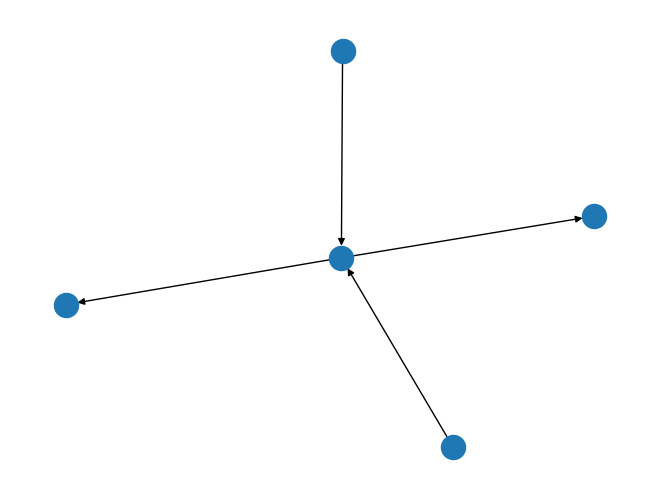

In [10]:
mpl_draw(backend.coupling_map.graph)

In [11]:
backend.operation_names

['r', 'cz', 'measure']

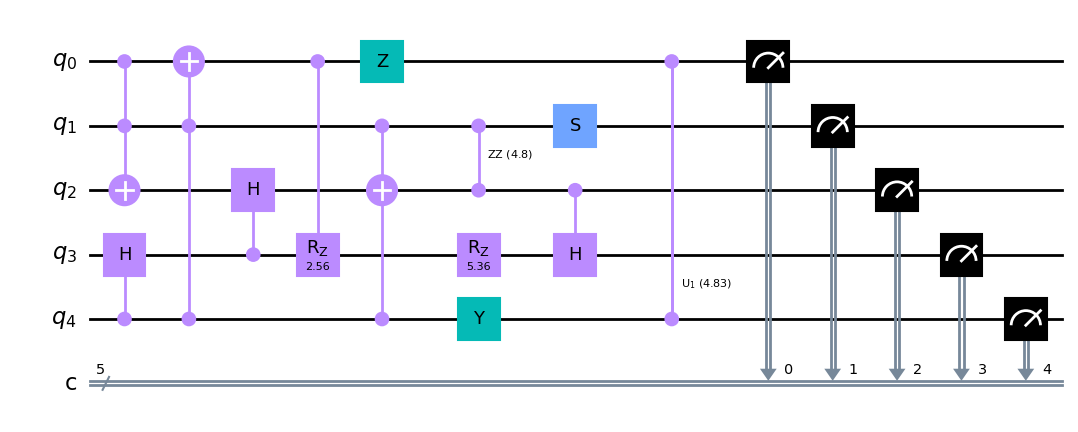

In [12]:
qc = random_circuit(5, 5, measure=True, seed=321)
qc.draw(output='mpl')

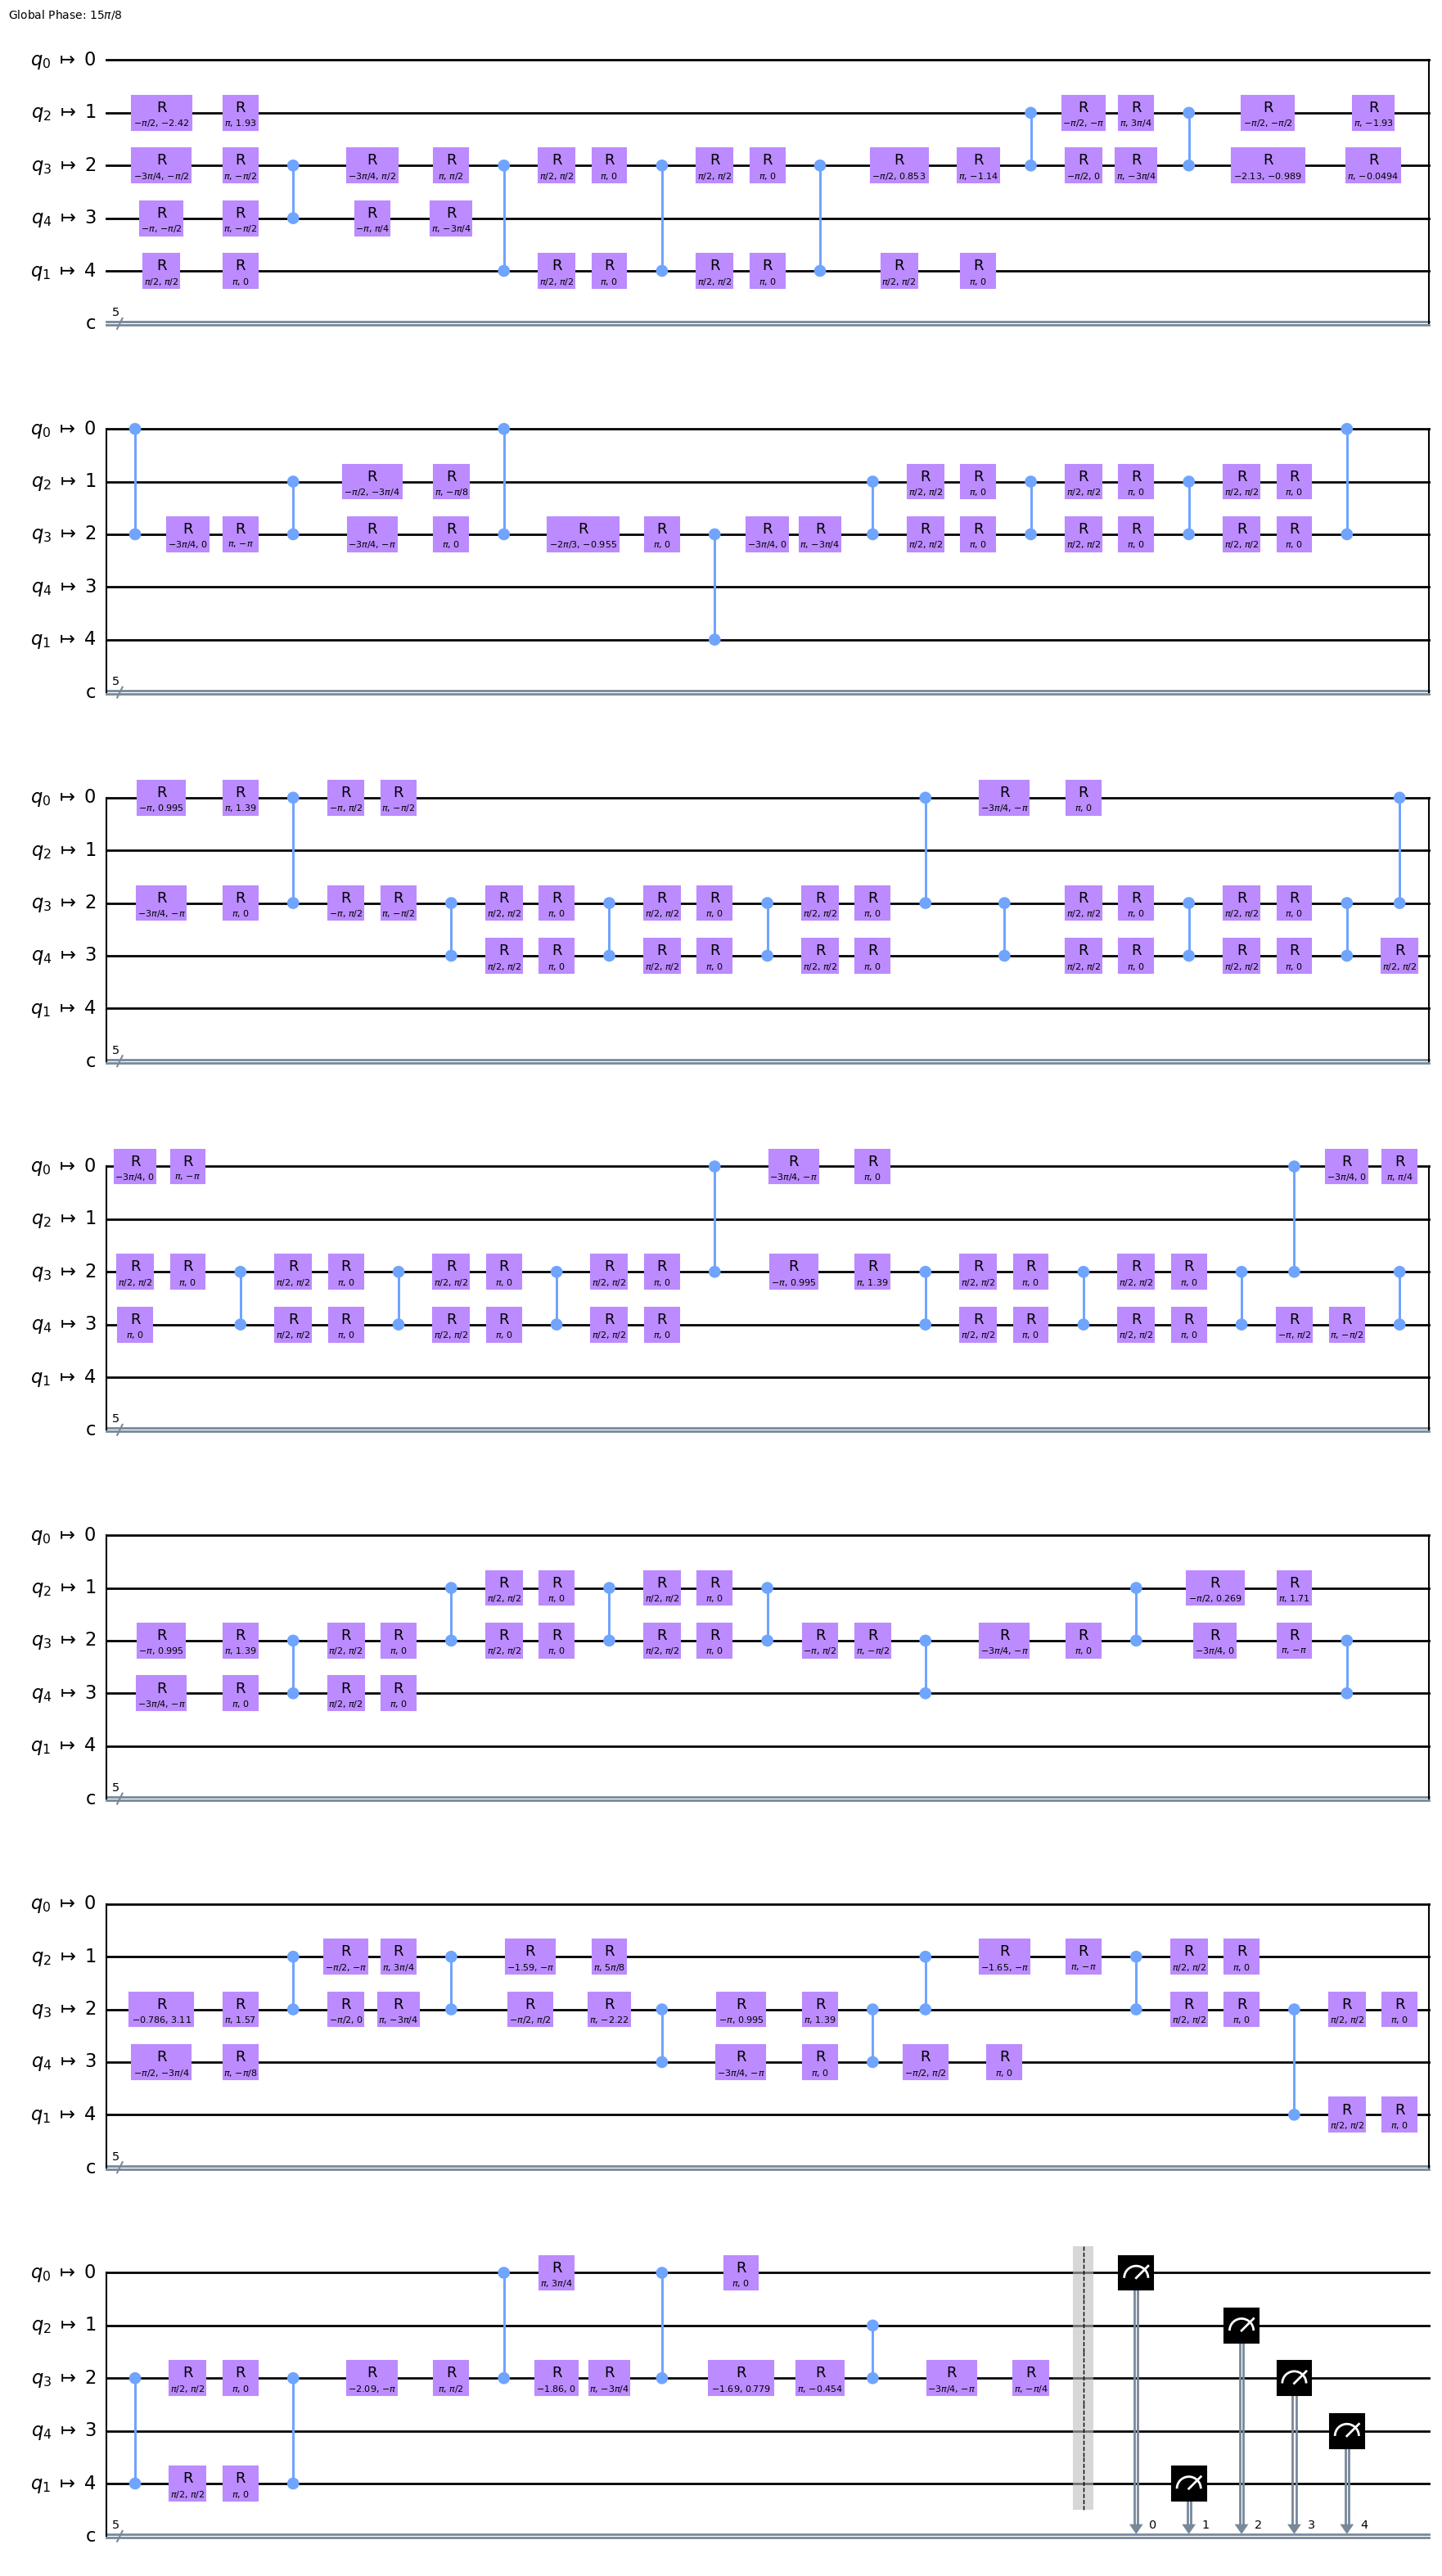

In [13]:
qc_transpiled = transpile(qc, backend=backend, optimization_level=3)
qc_transpiled.draw(output='mpl')

### 3. Execution

In [14]:
qc_1 = random_circuit(5, 5, measure=True, seed=123)
qc_2 = random_circuit(5, 5, measure=True, seed=456)

job = execute([qc_1, qc_2], backend, shots=1000)

And again, the job instance here is very important for interoperability with various tools in Qiskit, so we implement the abstract interface `JobV1` provided by Qiskit.

In [15]:
from qiskit.providers import JobV1

isinstance(job, JobV1)

True

### 4. IQM Job

In [16]:
job.status()

<JobStatus.DONE: 'job has successfully run'>